In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, math, random
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch

sys.path.append(os.path.abspath('..'))
from utils import imshow, imgrid
from src.gan import Discriminator, Generator, weights_init_normal
from src.sample import sample_perlin as sample
from src.repair import repair

img_size = 128
latent_size = 100
adversarial_loss = torch.nn.BCELoss()

def one_hot(a, num_classes):
    new_shape = (a.shape[0], a.shape[1]*num_classes)
    return np.eye(num_classes)[a].reshape(new_shape)

def get_batch(batch_size=100):
    imgs = np.stack([
        sample(img_size)
        for _ in range(batch_size)
    ])
    imgs = torch.from_numpy(imgs).float()
    return imgs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


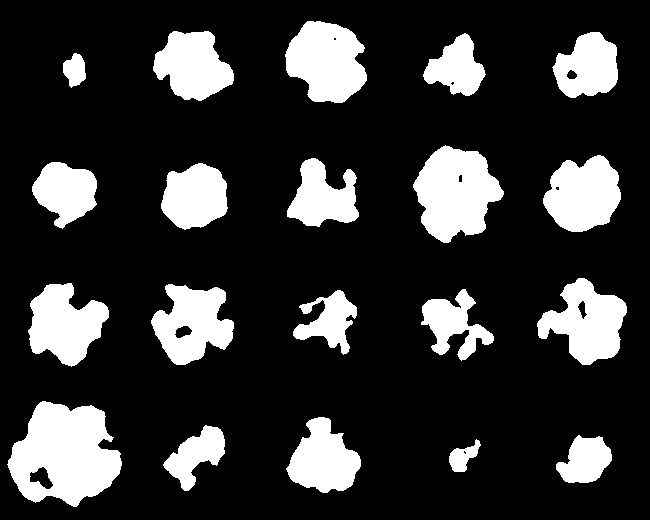

In [11]:
imshow(imgrid(np.stack([ repair(sample(img_size)) for _ in range(20) ])))

In [3]:
generator = Generator(img_size, latent_size).cuda()
discriminator = Discriminator(img_size).cuda()

In [4]:
lr = .0002 / 3
betas = (.5, .999)
batch_size = 128
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)
None

In [5]:
valid = torch.ones((batch_size, 1), requires_grad=False).cuda()
fake = torch.zeros((batch_size, 1), requires_grad=False).cuda()

In [6]:
def train(epoch):
    total_g_loss = 0
    total_d_loss = 0
    for batch_idx in tqdm(range(100)):
        #  Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_size).cuda()
        gen_imgs = generator(z)

        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Descriminator
        optimizer_D.zero_grad()
        
        real_imgs = get_batch(batch_size).unsqueeze(1).cuda()
        real_imgs = (real_imgs * 2) - 1
        
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()
    print(epoch, total_g_loss / batch_size,  total_d_loss / batch_size)

def display_test(n=10, cols=5):
    z = torch.randn(n, latent_size).cuda()
    gen_imgs = generator(z)[:, 0].detach().cpu().numpy()
    imshow(imgrid(gen_imgs, cols=cols))


0 0.4811172806657851 0.49615965923294425


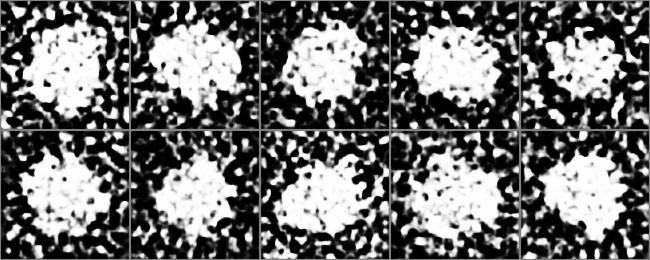


1 0.5803302451968193 0.514964162837714


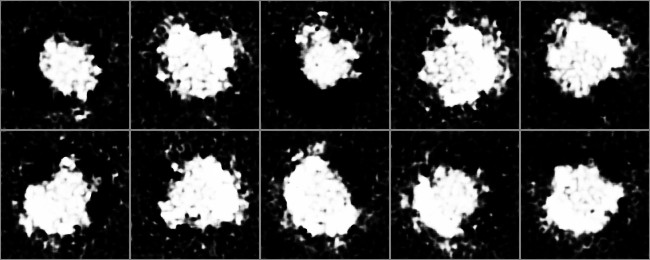


2 0.5494242087006569 0.5440890714526176


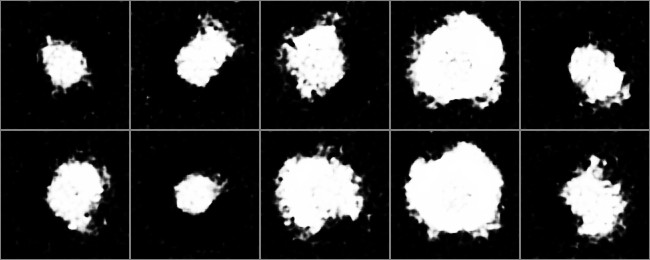


3 0.5663947970606387 0.540846501942724


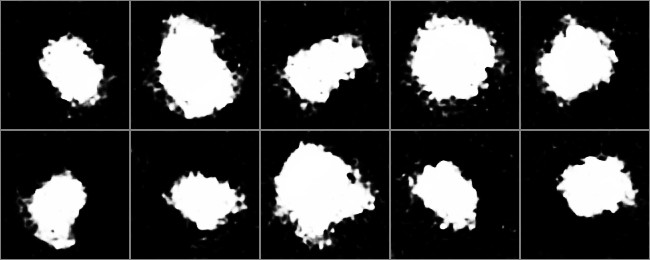


4 0.5606246222741902 0.5357782556675375


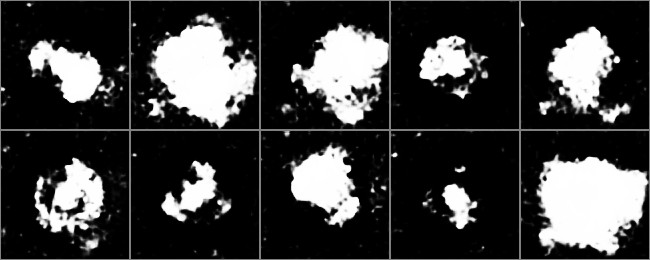


5 0.527612351346761 0.5420478293672204


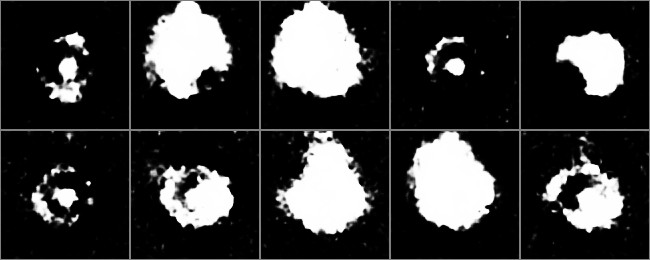


6 0.5473756305873394 0.5403327737003565


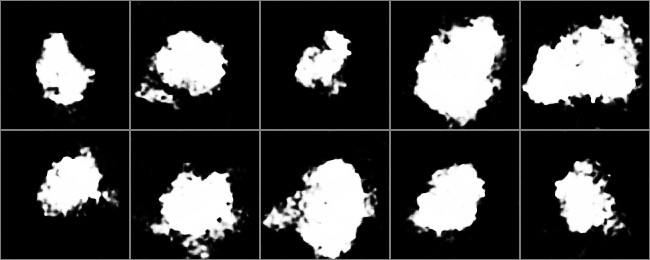


7 0.551233843434602 0.5408344259485602


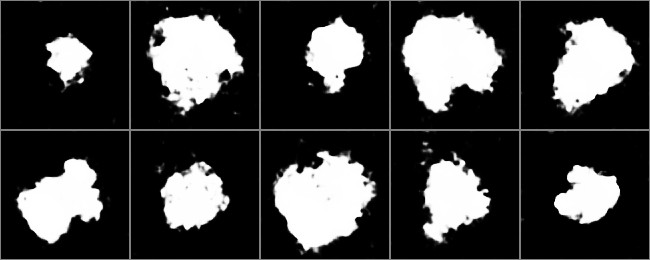


8 0.5485088978894055 0.5408384380862117


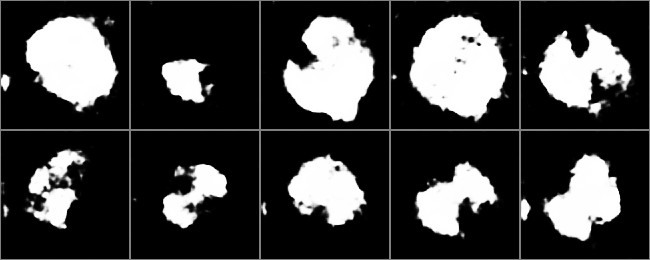


9 0.5320516522042453 0.5379426972940564


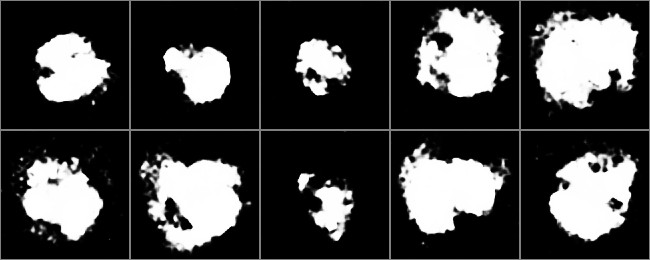


10 0.5553678027354181 0.5413008476607502


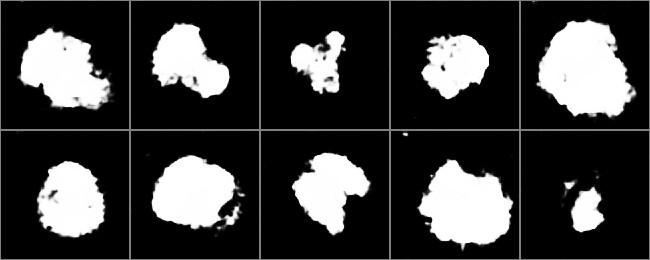


11 0.5393279553391039 0.5412300075404346


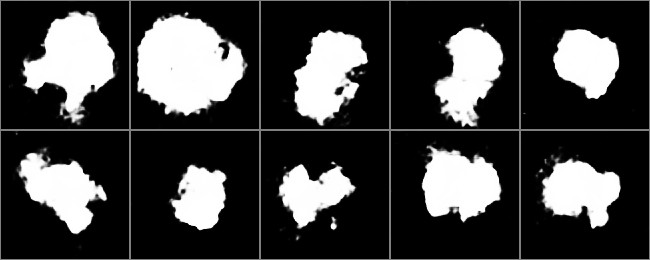


12 0.551716092042625 0.5420980583876371


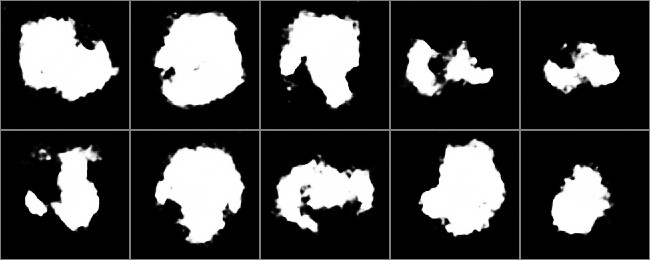


13 0.5537255378440022 0.5434276051819324


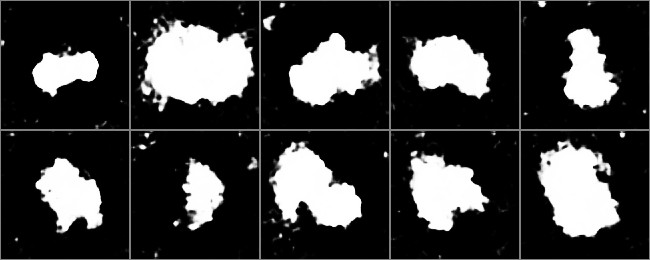


14 0.5504296850413084 0.542668140027672


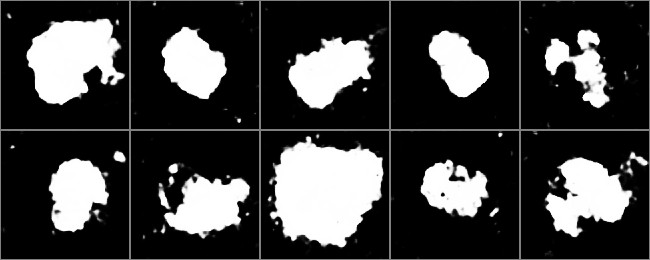


15 0.5507565550506115 0.540422928519547


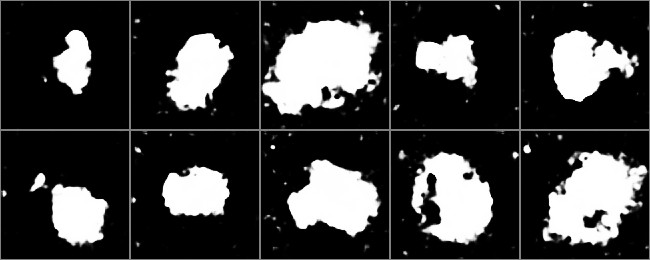

In [7]:
for epoch in range(16):
    if epoch in [12, 20]:
        for param_group in optimizer_G.param_groups:
            param_group['lr'] /= 3
        for param_group in optimizer_D.param_groups:
            param_group['lr'] /= 3
    train(epoch)
    display_test()

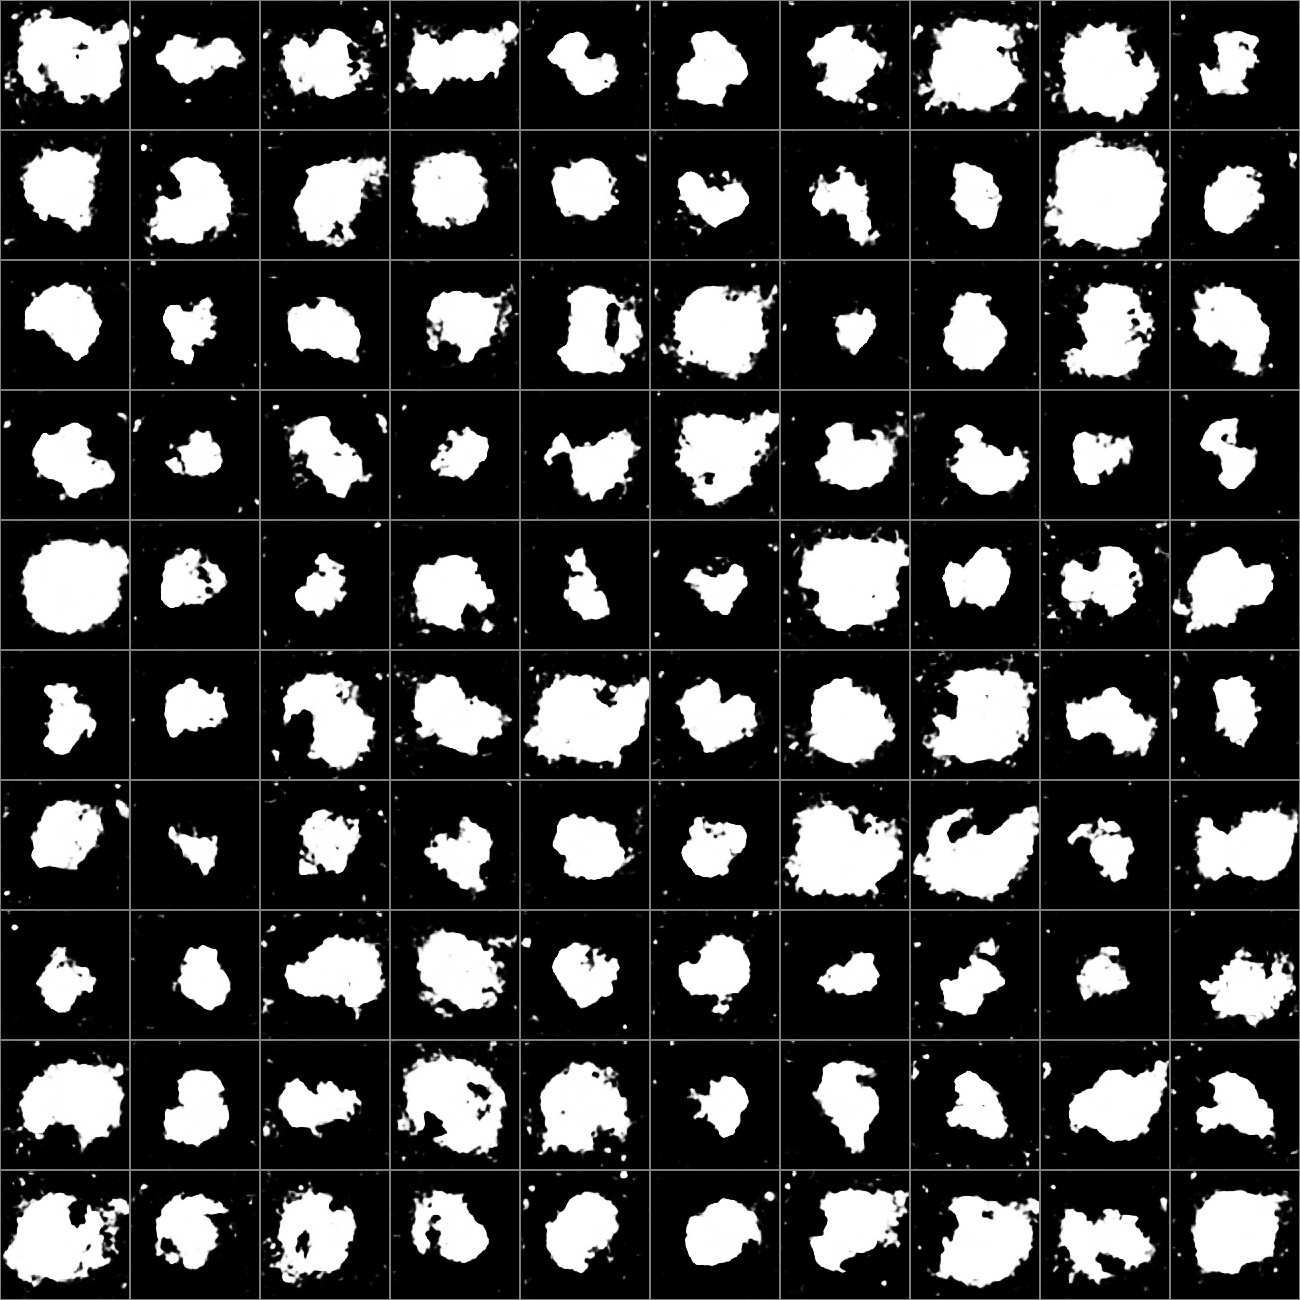

In [8]:
display_test(100, cols=10)

In [9]:
root = '/home/joel/Projects/FormsOfLife/saved_models'
torch.save(generator.state_dict(), f'{root}/dcgan_gen_{img_size}')
torch.save(discriminator.state_dict(), f'{root}/dcgan_desc_{img_size}')

In [10]:
img_size

128